In [0]:
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore');
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import seaborn as sns;
sns.set_context("notebook", font_scale=1.4);
sns.set_style("whitegrid");

In [0]:
###util methods
def plot_entropy_function():
	pvals = np.linspace(0, 1)        
	plt.plot(pvals, [entropy([p,1-p]) for p in pvals])
	plt.xlabel(r'$p_1=1-p_2$',fontsize=18)
	plt.ylabel('entropy')

# 6a. Decision trees

A **decision tree** is a flowchart-like structure in which each **internal node** represents a test on a feature, each **branch** represents a possible outcome of the test and each **leaf node** represents a target. The paths from root to leaf represent prediction rules. Decision trees can be used to solve both classification and regression tasks, but here we will restrict the description to classification trees. Here is an example of a decision tree:

In [10]:
from IPython.core.display import Image
Image("decisiontree.png")

The first test is performed in the **root node** (top node) and checks if feature "X[9]" has a value smaller than or equal to -0.5350. If it is then we follow the left branch in the flowchart, if it isn't we follow the right branch. This process is repeated until we reach a leaf node from which we obtain predicted class probabilities. 

The decision tree is built in a **top-down** fashion where the main question is how to choose which feature to split at each node? The answer is to find the feature that best splits the target class into the purest possible children nodes. This **measure of purity** is typically computed as the opposite of the **entropy** (which is a measure of impurity) of the class label probabilities in the data set. 

The idea behind classification decision tree construction is to assign an **entropy value to a set of data label probabilities** and use this entropy to find the **best split** at each node in the decision tree. Suppose we have a data set with 100 samples of which 20 belong to class 1 and 80 belong to class 2. For this data set the probability $p_1$ that a data point belongs to class 1 is 0.2, the probability $p_2$ that a data point belongs to class 2 is 0.8. 

The entropy $H$ of these two class label probabilities is computed as

$$H(p_1,p_2) = -p_1 log_2(p_1) -p_2 log_2(p_2).$$ 

More general the entropy of any number of probabilities is computed as

$$H(p_i) = -\sum_i p_i log_2(p_i),$$

where $i$ ranges over the class probabilities. Let's compute the entropy for the probability of the classes in our data set:

In [11]:
from scipy.stats import entropy

print(entropy([.2,.8],base=2))

0.7219280948873623


Now suppose our data set contains only one sample for class 1 and 99 for class 2:

In [12]:
print(entropy([.01,.99],base=2))

0.08079313589591118


The entropy for this data set is much lower. To maximize the entropy of a data set we have to create one with an equal number of samples for class 1 and 2:

In [13]:
print(entropy([.5,.5],base=2))

1.0


In this case the uncertainty about the classes is maximal. The **binary entropy function** for two classes looks like this:

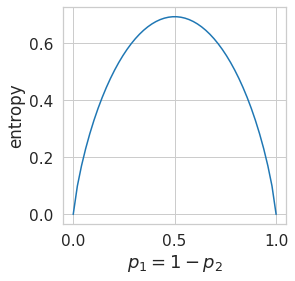

In [14]:
plt.figure(figsize=(4,4))
plot_entropy_function()
plt.show()

A decision tree is constructed by **recursively splitting** (partitioning) a data set $D$. For each split the learning algorithm finds the feature that *best* partitioned the data set. To find this feature we can use several criteria, one of them is called **information gain**.

Information gain is the difference between the current entropy of a system and the entropy measured after a feature is chosen. If $D$ is a set of samples and $x$ is a possible feature that partitions $D$ in subsets $D_v$, then:

$$G(D,x) = \text{Entropy}(D) - \sum\frac{|D_v|}{|D|} \text{Entropy}(D_v).$$

The **decision tree learning algorithm** computes the information gain for each feature and selects the one with the highest value. In this way, it searches the "tree space" according to a greedy strategy, i.e. not all possible trees are evaluated.

A tree is constructed by recursively selecting the feature from the current data set with the largest information gain and adding a test to the decision tree. Refer to "Informatica II" for the details on how to construct a decision tree using the information gain criterion.

Decision trees can become very complex which makes them prone to overfitting the train set. To prevent this, the decision tree learning algorithm stops growing the tree if the information gain is not sufficient to justify the extra complexity of adding another node. Other **stopping criteria** exist such as limiting the number of samples in a node or limiting the depth of the tree.

Let's load a data set that contains information about translation initiation sites (TIS) in genes [1]. The data set contains feature vectors that each represent a nucleotide sequence of length 203. The middle three nucleotides in these sequences are always ATG (i.e. candidate TIS) and are labeled '1' (positive class) if they form the start of a translation of a gene and '0' (negative class) otherwise: 

In [15]:
dataset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554/master/notebooks/6_ensemble_learning/TIS.csv")
print(dataset.head())

   UP_A  DOWN_A  UP_R  DOWN_R  UP_N  ...  UP_Y  DOWN_Y  UP_V  DOWN_V  label
0     0       3     0       1     0  ...     0       0     0       1      0
1     5       2     3       3     0  ...     0       0     2       3      1
2     4       3     3       3     1  ...     0       0     0       4      0
3     1       0     0       1     0  ...     0       1     0       1      1
4     0       0     1       1     0  ...     0       1     0       1      0

[5 rows x 41 columns]


The features are straightforward. For instance the feature "UP_A" counts the number of codons coding for amino acid A that are found in the upstream region of the sequence (relative to the candidate TIS), while feature "DOWN_V" counts the number of codons coding for amino acid V that are found in the downstream region of the sequence. So, there are 40 features (+1 column for the label):

In [16]:
print(dataset.shape)

(1000, 41)


About 25% of the data points are labeled as positive:

In [17]:
print(dataset['label'].value_counts() / dataset['label'].count())

0    0.729
1    0.271
Name: label, dtype: float64


In scikit-learn there is the `DecisionTreeClassifier` module that computes a decision tree. Here we optimize the maximum tree depth for the decision tree using `GridSearchCV` and estimate the generalization performance using nested cross-validation:

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

X = dataset.copy()
y = X.pop('label')

np.random.seed(1)

search_space = {'max_depth':[4,8,16]}
model = DecisionTreeClassifier(criterion='entropy')
grid_search = GridSearchCV(model, param_grid=search_space, cv=5)

cv_predictions = cross_val_predict(grid_search, X, y, method="predict_proba")

fpr, tpr, thresholds = metrics.roc_curve(y, cv_predictions[:,1])
print(metrics.auc(fpr, tpr))

0.7264564003664729


Decision trees have several advantages: 

* ease of interpretation
* handles continuous and discrete features
* invariant to monotone transformation of features
* variable selection automated
* low bias (for deep trees)

The disadvantage is that decision trees show high variance and a are prone to overfitting.

In the next chapter we will discuss the meaning of bias and variance in the context of a machine learning algorithm.

**Reference**

[1] Pedersen AG, Nielsen H. Proceedings 5th International Conference on Intelligent Systems for Molecular Biology. 1997. Neural network prediction of translation initiation sites in eukaryotes: perspectives for EST and genome analysis; pp. 226–233.